In [ ]:
# install lightgbm if missing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sentence_transformers import SentenceTransformer
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


In [16]:
file_path = r"C:\Users\Shanmuga Shyam. B\OneDrive\Desktop\SIH25180\web-scarpping\completion_reports_with_json.xlsx"

xls = pd.ExcelFile(file_path)
dfs = []

for s in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=s)
    df["_sheet_source"] = s
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
data.head()


,Selected Year,Sl No,Title,Project Code,Implementing Agency,Financial Year,Cost (Lakhs),PDF Link,Extracted_JSON,_sheet_source
0,2023-24,2,Indigenous Development of IoT Enabled Technolo...,MT-172,"CMPDI, Ranchi, IIT, Kharagpur & ECL, Sanctoria",2023-24,471.00,https://scienceandtech.cmpdi.co.in/Project_com...,"{""text"": ""Indigenous Development of IoT Enable...",Sheet1
1,2023-24,3,Indigenous development of early warning radar ...,MT-169,"SAMEER, Mumbai, CSRE, IIT, Bombay & CMPDI, Ranchi",2023-24,585.58,https://scienceandtech.cmpdi.co.in/Project_com...,"{""text"": ""Indigenous Development of Early Warn...",Sheet1
2,2023-24,4,Assessment of Rare Earth Elements (REE) and ot...,EE-51,"Panjab University, Chandigarh, CMPDI, Ranchi &...",2023-24,361.38,https://scienceandtech.cmpdi.co.in/Project_com...,"{""text"": ""Page 2 of 171/EE -51 Abstract \n \...",Sheet1
3,2022-23,2,Development of Coal Quality Exploration Techni...,CP-50,"CIMFR, Nagpur & Shri Ramdeobaba College of Eng...",2022-23,103.59,https://scienceandtech.cmpdi.co.in/Project_com...,"{""text"": ""i \n Executive Summary \nCoal is In...",Sheet1
4,2022-23,3,Modelling and design of indirect coal gasifica...,CE-34,"IIT Madras, Chennai and CMPDI, Ranchi",2022-23,72.07,https://scienceandtech.cmpdi.co.in/Project_com...,"{""text"": ""1 \n Summary \nDepending upon the s...",Sheet1


In [ ]:
abstract_col = "Extracted_JSON"   # <-- change if needed
year_col = "Financial Year"           # <-- change if needed
cost_col = "Cost (Lakhs)"           # <-- change if needed

df = data[[abstract_col, year_col, cost_col]].dropna()
df.head()


,Extracted_JSON,Financial Year,Cost (Lakhs)
0,"{""text"": ""Indigenous Development of IoT Enable...",2023-24,471.00
1,"{""text"": ""Indigenous Development of Early Warn...",2023-24,585.58
2,"{""text"": ""Page 2 of 171/EE -51 Abstract \n \...",2023-24,361.38
3,"{""text"": ""i \n Executive Summary \nCoal is In...",2022-23,103.59
4,"{""text"": ""1 \n Summary \nDepending upon the s...",2022-23,72.07


In [19]:
X_text = df[abstract_col].tolist()
X_year = df[[year_col]].values
y = df[cost_col].values


In [20]:
sbert = SentenceTransformer("all-MiniLM-L6-v2")


In [21]:
X_text_embed = sbert.encode(X_text, show_progress_bar=True)
X_text_embed.shape


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(50, 384)

In [22]:
X_combined = np.hstack([X_text_embed, X_year])
X_combined.shape


(50, 385)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)


In [25]:
# Convert trailing year column (e.g. '2018-19') to a numeric feature (start year)
def _convert_year_column(X):
    X = np.asarray(X, dtype=object)
    # numeric features are all columns except last
    feats = X[:, :-1].astype(float)
    years = X[:, -1]
    def _parse_year(y):
        try:
            s = str(y)
            if '-' in s:
                return int(s.split('-')[0])
            return int(s)
        except:
            return np.nan
    year_nums = np.array([_parse_year(y) for y in years]).reshape(-1, 1)
    return np.hstack([feats, year_nums])

X_train_num = _convert_year_column(X_train)
X_test_num = _convert_year_column(X_test)

model = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=40
)

model.fit(X_train_num, y_train)

# optional: predict for evaluation later
y_pred_lgb = model.predict(X_test_num)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 40, number of used features: 74
[LightGBM] [Info] Start training from score 608.818385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [27]:
# predict using numeric test data (year converted to numeric)
y_pred = model.predict(X_test_num)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)


RMSE: 644.2232357109631
R² Score: -60.22294371785255


c:\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


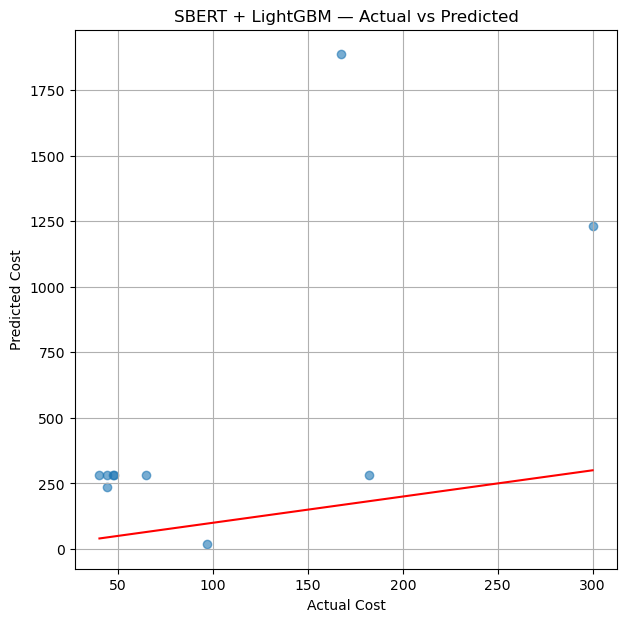

In [28]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], color='red')

plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("SBERT + LightGBM — Actual vs Predicted")
plt.grid(True)
plt.show()


In [29]:
import joblib
joblib.dump(model, "SBERT_LightGBM_cost_model.joblib")
joblib.dump(sbert, "SBERT_text_encoder.joblib")


['SBERT_text_encoder.joblib']